**Pedestrian Detection with OpenCV (Haar Cascade & HOG)**

**Why Pedestrian Detection?**

- Detecting people in videos/images is a key task in Computer Vision.
- Useful for:
  
  - Self-driving cars (detecting pedestrians to avoid accidents)
  - CCTV & surveillance (detecting suspicious activities)
  - Smart cities (counting people, monitoring crowds)
  - Sports analysis (tracking players)
  - Human-computer interaction

**Advantages**

- Automates monitoring tasks  
- Helps in safety-critical systems (e.g., autonomous vehicles)  
- Works in real time with modern detectors  

**Limitations**

- Traditional methods (Haar, HOG) are **CPU-heavy** and may miss side/partially visible people  
- Sensitive to lighting, clothing, and occlusion (e.g., if person is behind another person)  
- Deep learning (YOLO, SSD) is better but requires more setup (GPU recommended)  



**Algorithms we will use:**

1. **Haar Cascade (classic method)**

   - Uses a pretrained XML file (`haarcascade_fullbody.xml`) trained on many images
   - Works well for **frontal full-body people**
   - Limitation: Misses people from side or partial view



2. **HOG + SVM (Histogram of Oriented Gradients + Support Vector Machine)**

   - Extracts gradient features and matches against a human-shaped model
   - More robust for **walking people and side views**
   - Built into OpenCV (`cv2.HOGDescriptor_getDefaultPeopleDetector`)


# Imports & Helpers
Before starting, we need to import Python libraries:

- `cv2` → OpenCV, the main computer vision library
- `numpy` → used for handling arrays and numerical operations
- `PIL.Image` → to display frames as images inside Jupyter
- `IPython.display` → to show video frames inline in the notebook


In [1]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display, clear_output

# Helper function to display frames inline in Jupyter Notebook
def show_frame_notebook(bgr_frame):
    """Convert BGR frame (OpenCV) → RGB (PIL) and display inline."""
    rgb = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(rgb)
    clear_output(wait=True)
    display(img)

# Haar Cascade
**Haar Cascade — Step 1: Download the pretrained XML file**

- Haar cascades are trained models stored as `.xml` files.
- OpenCV provides them here:
  https://github.com/opencv/opencv/tree/master/data/haarcascades
- For full body detection: `haarcascade_fullbody.xml`
- Place the file in a folder called `Haarcascades/` (next to your notebook).


# Haar Cascade Load & Test
Now we:

- Load the Haar cascade file
- Check if it loaded successfully
- Load our video (`walking.mp4`) for testing


In [2]:
HAAR_PATH = "haarcascade_fullbody.xml"
VIDEO_PATH = "walking.mp4"

# Load Haar cascade
body_classifier = cv2.CascadeClassifier(HAAR_PATH)
print("Cascade loaded:", not body_classifier.empty())

# Load video
cap = cv2.VideoCapture(VIDEO_PATH)
print("Video opened:", cap.isOpened())
cap.release()


Cascade loaded: True
Video opened: True


# Haar Cascade Detection

**Steps:**

1. Open video with `cv2.VideoCapture`
2. Resize each frame for speed
3. Convert to grayscale (Haar works on gray images)
4. Run `detectMultiScale`:
   - `scaleFactor` → how much image size is reduced per scale (smaller = more detection, slower)
   - `minNeighbors` → how many neighbors a rectangle should have to be kept (higher = fewer false positives)
   - `minSize` → ignore very small detections
5. Draw bounding boxes
6. Show frames inline in notebook


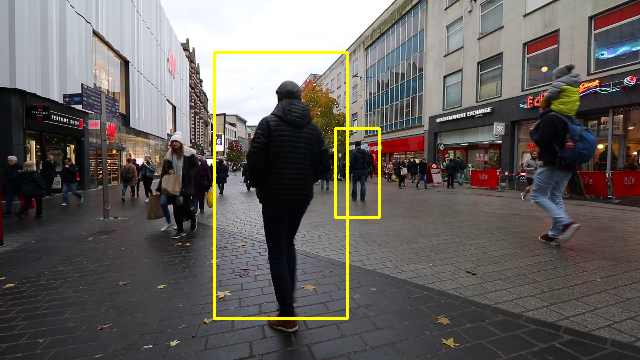

In [5]:
cap = cv2.VideoCapture(VIDEO_PATH)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (640, 360))
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    bodies = body_classifier.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=3,
        minSize=(40, 80)
    )

    for (x, y, w, h) in bodies:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)

    show_frame_notebook(frame)

cap.release()


# HOG + SVM Detector
**Why HOG + SVM?**

- Haar cascades often miss side-view pedestrians.
- HOG (Histogram of Oriented Gradients) extracts gradient-based features that represent human shapes.
- OpenCV provides a pretrained people detector with SVM.
- Works better for walking people.

**Steps:**
    
1. Initialize HOG descriptor
2. Set default people detector
3. Detect people with `hog.detectMultiScale`
4. Apply non-max suppression to reduce overlapping boxes


# HOG + SVM Detection

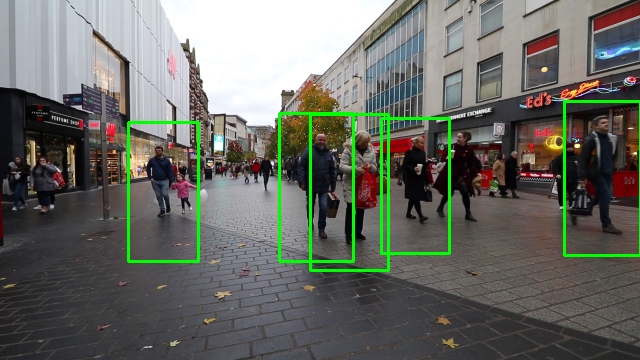

KeyboardInterrupt: 

In [4]:
from imutils.object_detection import non_max_suppression
import imutils

cap = cv2.VideoCapture(VIDEO_PATH)

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = imutils.resize(frame, width=640)

    # Detect people
    (rects, weights) = hog.detectMultiScale(frame, winStride=(4,4), padding=(8,8), scale=1.05)

    # Apply non-max suppression (reduce overlapping boxes)
    rects_np = np.array([[x, y, x+w, y+h] for (x,y,w,h) in rects])
    pick = non_max_suppression(rects_np, probs=None, overlapThresh=0.65)

    for (xA, yA, xB, yB) in pick:
        cv2.rectangle(frame, (xA, yA), (xB, yB), (0, 255, 0), 2)

    show_frame_notebook(frame)

cap.release()


# Summary

- **Haar Cascade**
  - Easy to use, requires XML pretrained file
  - Works on grayscale frames
  - Limited: misses side/partially visible people

- **HOG + SVM**
  - Built into OpenCV
  - Works better for walking people and side views
  - More robust but heavier on CPU

For **best accuracy in modern applications**, deep learning models like YOLO or SSD are used (future work).


# Frontend: Streamlit App

We created a **Streamlit app (`app.py`)** that allows:

- Uploading an **image** → detection results shown instantly.
- Uploading a **video** → detection runs frame by frame, displayed in the browser.
- (Optional) **Webcam capture** → capture one snapshot and run detection.



##  Steps to Run

### **Install Dependencies**
   ```bash
   pip install streamlit opencv-python imutils pillow
````

### **Create `app.py`**

   * Copy the Streamlit code provided into a file named `app.py`.

### **Run the App**

   ```bash
   streamlit run app.py
   ```

### **Access the App**

   * Open the URL shown in the terminal (e.g., `http://127.0.0.1:8501`).



##  How the App Works

* **Image Mode**

  * Upload a JPG/PNG.
  * The system detects pedestrians and draws bounding boxes.

* **Video Mode**

  * Upload an MP4/AVI.
  * Each frame is processed → results displayed in real-time.

* **Webcam Mode**

  * Capture a single photo using your webcam.
  * Detection is applied to the snapshot.



#  Output Results

Below are the screenshots showing the working of our **Pedestrian Detection App**:

- **App_look_1.png** → Application UI look when launched.  
- **Image_2.png** → Detection results on an uploaded image.  
- **Video_3.png** → Detection results on a video (wide/angle view).  
- **Video_4.png** → Detection results on a video (close and front view).  

## Screenshots

**1.App Look**

![App Look](Output/App_look_1.PNG)

**2.Image Detection**

![Image Detection](Output/Image_2.png)

**3.Video Detection – Wide Angle**

![Video Wide](Output/Video_3.png)

**4.Video Detection – Close/Front**

![Video Close](Output/Video_4.png)
